In [3]:
# gru 모델

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 전처리된 데이터 로드

# 특성 데이터 로드
X_train_scaled = joblib.load('../processed_data/X_train_scaled.pkl')
X_val_scaled = joblib.load('../processed_data/X_val_scaled.pkl')
X_test_scaled = joblib.load('../processed_data/X_test_scaled.pkl')

# 라벨 데이터 로드
y_train = joblib.load('../processed_data/y_train.pkl')
y_val = joblib.load('../processed_data/y_val.pkl')
y_test = joblib.load('../processed_data/y_test.pkl')

# 공통 스케일러 로드
scaler = joblib.load('../models/scaler.pkl')

print(f"데이터 로드 완료:")
print(f"  특성 데이터:")
print(f"    - X_train: {X_train_scaled.shape} (samples, timesteps, features)")
print(f"    - X_val:   {X_val_scaled.shape}")
print(f"    - X_test:  {X_test_scaled.shape}")

print(f"  라벨 데이터:")
print(f"    - y_train: {y_train.shape} (고장 비율: {y_train.sum()/len(y_train)*100:.1f}%)")
print(f"    - y_val:   {y_val.shape} (고장 비율: {y_val.sum()/len(y_val)*100:.1f}%)")
print(f"    - y_test:  {y_test.shape} (고장 비율: {y_test.sum()/len(y_test)*100:.1f}%)")

print(f"  스케일러: 특성 {scaler.n_features_in_}개 정규화 완료")

# 데이터 형태 확인
window_size = X_train_scaled.shape[1]
n_features = X_train_scaled.shape[2]
print(f"\n모델 입력 차원:")
print(f"  - 윈도우 크기: {window_size}")
print(f"  - 특성 개수: {n_features}")


데이터 로드 완료:
  특성 데이터:
    - X_train: (1498, 10, 32) (samples, timesteps, features)
    - X_val:   (313, 10, 32)
    - X_test:  (315, 10, 32)
  라벨 데이터:
    - y_train: (1498,) (고장 비율: 30.3%)
    - y_val:   (313,) (고장 비율: 31.0%)
    - y_test:  (315,) (고장 비율: 31.1%)
  스케일러: 특성 32개 정규화 완료

모델 입력 차원:
  - 윈도우 크기: 10
  - 특성 개수: 32


In [4]:
# 2. GRU 모델 구축

# GRU 모델
model = Sequential([
    # GRU 레이어 1
    GRU(64, activation='tanh', return_sequences=True,
        input_shape=(window_size, n_features)),
    Dropout(0.2),
    
    # GRU 레이어 2
    GRU(32, activation='tanh'),
    Dropout(0.2),
    
    # Dense
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    # 출력
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# 모델 구조 출력
print("\n 모델 구축 완료:")
model.summary()

print("\n 모델 정보")
print(f"  - 입력: (None, {window_size}, {n_features})")
print(f"  - 출력: (None, 1) - 고장 확률")
print(f"  - 파라미터: {model.count_params():,}개") #LSTM 대비: 더 적은 파라미터 (더 빠른 학습)"


 모델 구축 완료:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 64)         │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,769 (112.38 KB)

 Trainable params: 28,769 (112.38 KB)

 Non-trainable params: 0 (0.00 B)


 모델 정보
  - 입력: (None, 10, 32)
  - 출력: (None, 1) - 고장 확률
  - 파라미터: 28,769개


In [5]:
# 3. 모델 학습

# Early Stopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 학습 결과 요약
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("\n학습 완료! 최종 성능:")
print(f"  Train Loss: {final_train_loss:.4f}")
print(f"  Train Acc:  {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Val Loss:   {final_val_loss:.4f}")
print(f"  Val Acc:    {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# 과적합 체크
gap_train_val = final_train_acc - final_val_acc
print(f"\n과적합 체크:")
print(f"  Train-Val 차이: {gap_train_val:.4f} ({gap_train_val*100:.2f}%p)")

if gap_train_val > 0.1:
    print("  과적합 가능성 높음 (차이 > 10%)")
elif gap_train_val > 0.05:
    print("  약간 과적합 (차이 5~10%)")
else:
    print("  과적합 없음 (차이 < 5%)")

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9559 - loss: 0.1978 - precision: 0.9826 - recall: 0.8700 - val_accuracy: 0.9968 - val_loss: 0.0177 - val_precision: 1.0000 - val_recall: 0.9897
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0287 - precision: 1.0000 - recall: 0.9890 - val_accuracy: 1.0000 - val_loss: 0.0072 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0169 - precision: 1.0000 - recall: 0.9912 - val_accuracy: 0.9872 - val_loss: 0.0318 - val_precision: 0.9604 - val_recall: 1.0000
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0109 - precision: 1.0000 - recall: 0.9934 - val_accuracy: 0.9169 - val_loss: 0.1796 - val_precision: 0.7886 - val_recall: 1.0000
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0097 - precision: 0.9956 - recall: 0.9956 - val_accuracy: 0.9968 - val_loss: 0.0102

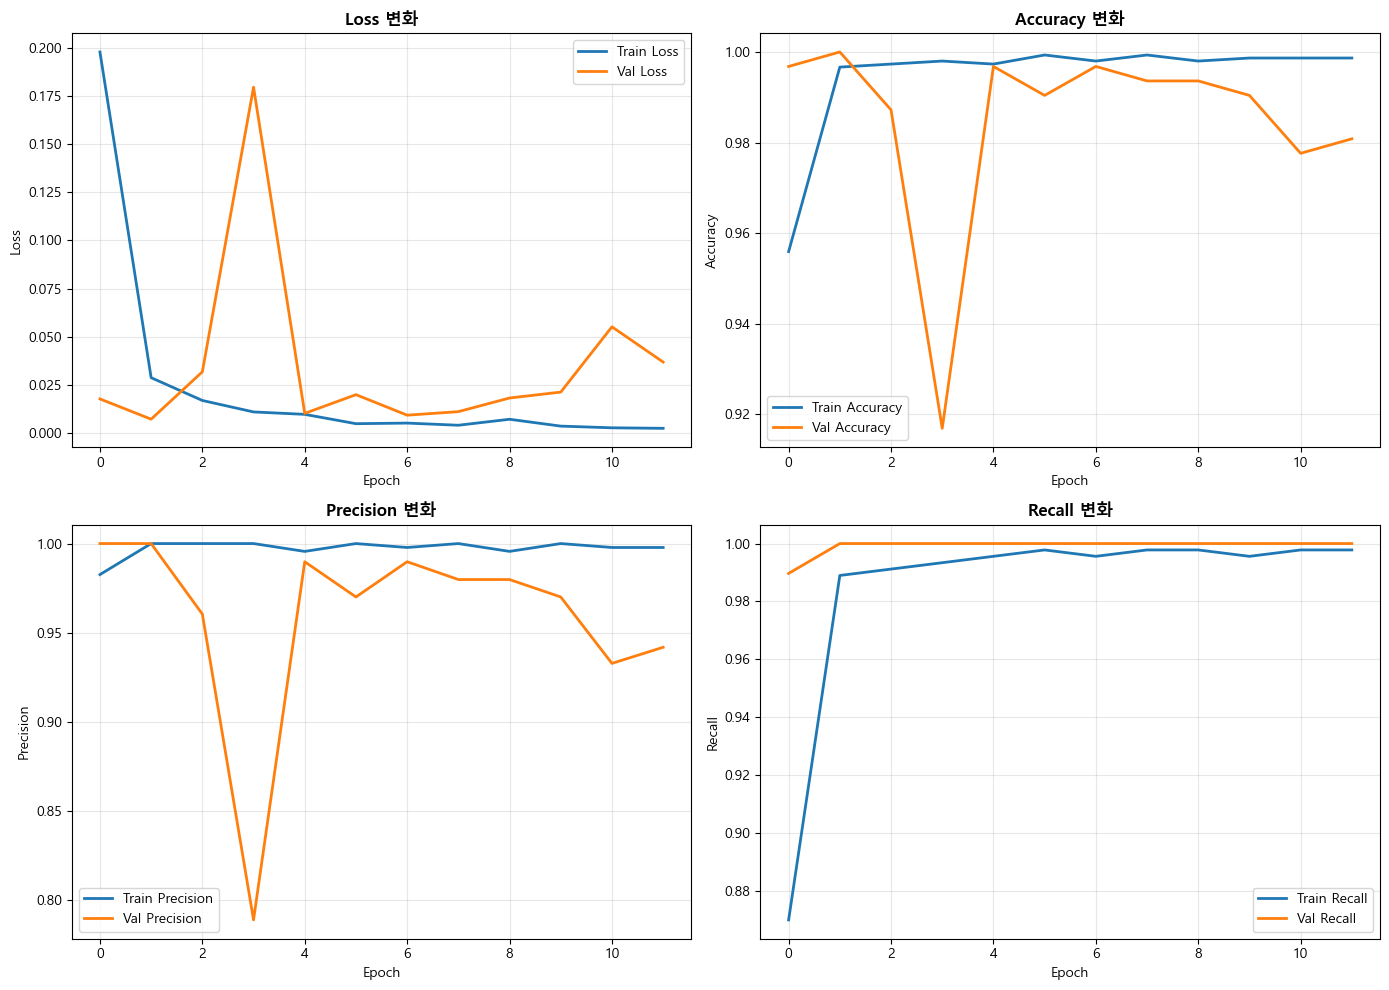

In [6]:
# 4. 학습 곡선 시각화

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
ax = axes[0, 0]
ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax.set_title('Loss 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy
ax = axes[0, 1]
ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax.set_title('Accuracy 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Precision
ax = axes[1, 0]
ax.plot(history.history['precision'], label='Train Precision', linewidth=2)
ax.plot(history.history['val_precision'], label='Val Precision', linewidth=2)
ax.set_title('Precision 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.legend()
ax.grid(True, alpha=0.3)

# Recall
ax = axes[1, 1]
ax.plot(history.history['recall'], label='Train Recall', linewidth=2)
ax.plot(history.history['val_recall'], label='Val Recall', linewidth=2)
ax.set_title('Recall 변화', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# 5. Test 성능 평가

# 예측
y_pred_prob = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 성능 지표 계산
test_acc = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print(f"\nTest 성능:")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)
print(f"  TN (정상→정상):  {cm[0,0]}")
print(f"  FP (정상→고장):  {cm[0,1]} (거짓 경보)")
print(f"  FN (고장→정상):  {cm[1,0]} (고장 놓침)")
print(f"  TP (고장→고장):  {cm[1,1]}")

# 분류 리포트
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['정상 (0)', '고장 (1)']))


Test 성능:
  Accuracy:  0.7778 (77.78%)
  Precision: 0.5833 (58.33%)
  Recall:    1.0000 (100.00%)

Confusion Matrix:
[[147  70]
 [  0  98]]
  TN (정상→정상):  147
  FP (정상→고장):  70 (거짓 경보)
  FN (고장→정상):  0 (고장 놓침)
  TP (고장→고장):  98

Classification Report:
              precision    recall  f1-score   support

      정상 (0)       1.00      0.68      0.81       217
      고장 (1)       0.58      1.00      0.74        98

    accuracy                           0.78       315
   macro avg       0.79      0.84      0.77       315
weighted avg       0.87      0.78      0.79       315



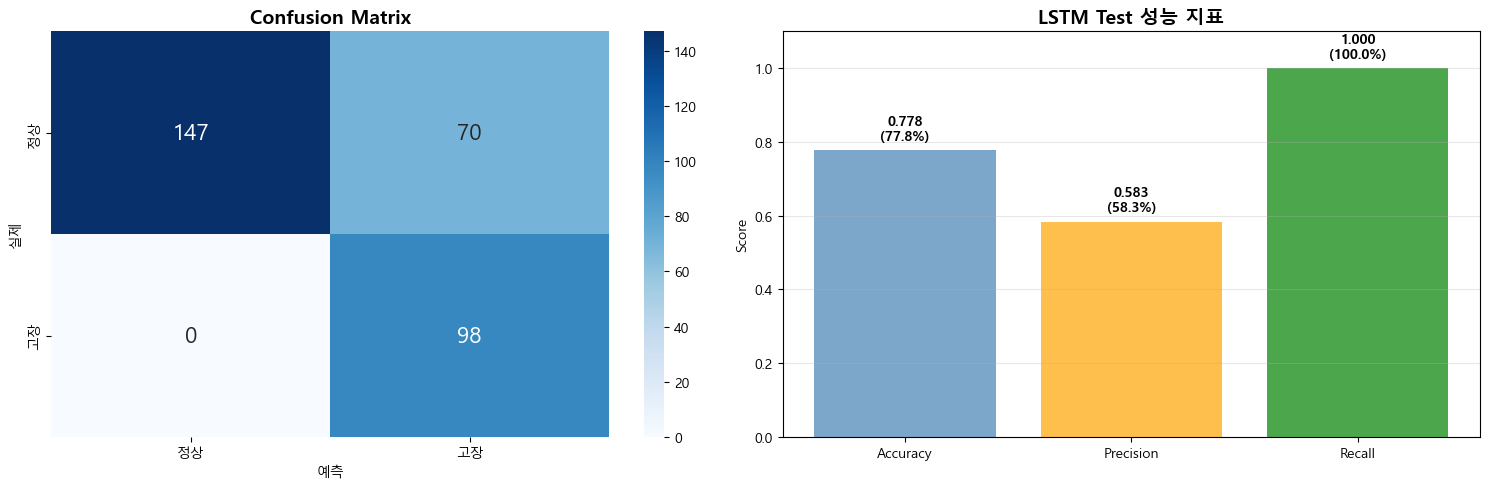

In [8]:
# 6. 결과 시각화

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix 히트맵
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['정상', '고장'],
            yticklabels=['정상', '고장'],
            ax=ax, cbar=True, annot_kws={'size': 16})
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('예측')
ax.set_ylabel('실제')

# 성능 지표 비교
ax = axes[1]
metrics = ['Accuracy', 'Precision', 'Recall']
values = [test_acc, test_precision, test_recall]
colors = ['steelblue', 'orange', 'green']

bars = ax.bar(metrics, values, color=colors, alpha=0.7)
ax.set_ylim(0, 1.1)
ax.set_title('GRU Test 성능 지표', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.3f}\n({value*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# 7. 모델 및 결과 저장

# 저장 경로
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# GRU 모델 저장
model_save_path = f'{models_dir}/model_gru.keras'
model.save(model_save_path)
print(f"GRU 모델 저장: {model_save_path}")

# 결과 딕셔너리 생성
results_gru = {
    'model_name': 'GRU',
    'model_type': 'deep_learning',
    'model_file': 'model_gru.keras',  # 모델 파일 경로
    'accuracy': test_acc,
    'precision': test_precision,
    'recall': test_recall,
    'confusion_matrix': cm.tolist(),  # numpy → list 변환
    'y_true': y_test.tolist(),
    'y_pred': y_pred.tolist(),
    'y_pred_prob': y_pred_prob.flatten().tolist(),
    'training_history': history.history,  # 학습 곡선 데이터
    'model_params': model.count_params(),
    'input_shape': (window_size, n_features),
    'epochs_trained': len(history.history['loss'])
}

# 결과 저장
results_save_path = f'{models_dir}/results_gru.pkl'
joblib.dump(results_gru, results_save_path)
print(f"GRU 결과 저장: {results_save_path}")

print(f"\n저장된 파일들:")
print(f"  - model_gru.keras: 모델 가중치 및 구조")
print(f"  - results_gru.pkl: 성능 지표 및 메타데이터")
print(f"  - scaler.pkl: 정규화 스케일러 (공용)")

# GRU vs LSTM 파라미터 비교
print(f"\n모델 복잡도:")
print(f"  - GRU 파라미터: {model.count_params():,}개")
print(f"  - LSTM 대비 약 25% 적은 파라미터 (게이트 구조 차이)")

GRU 모델 저장: ../models/model_gru.keras
GRU 결과 저장: ../models/results_gru.pkl

저장된 파일들:
  - model_gru.keras: 모델 가중치 및 구조
  - results_gru.pkl: 성능 지표 및 메타데이터
  - scaler.pkl: 정규화 스케일러 (공용)

모델 복잡도:
  - GRU 파라미터: 28,769개
  - LSTM 대비 약 25% 적은 파라미터 (게이트 구조 차이)


# GRU 모델 결과 요약

## 성능
- **Test Accuracy**: 77.78%
- **Test Precision**: 58.33%
- **Test Recall**: 100.00%
- **Test F1-score**: 74.00%

## 주요 발견
- 고장 98개 모두 감지 성공 (놓침 0개)
- LSTM 대비 약간 높은 Precision (58.33% vs 56.32%)
- 더 적은 파라미터로 효율적 학습 (약 25% 감소)
- 거짓 경보 70개 발생 (LSTM 76개보다 개선)

## 다음 단계
- CNN 모델 구현 (05_cnn.ipynb)
- 1D CNN으로 시계열 특성 추출 및 고장 예측
